### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Image and Labels Loading and Matching

In [2]:
# Load the Data from CSV
csv_file = "clean_MovieGenre.csv"  # Path to your CSV file
df = pd.read_csv(csv_file)

# Specify the binarized columns
binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 
                     'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

In [3]:
image_folder = "downloaded_images" 
images = []
labels = []
batch_size = 128  

# Load images and labels in batches
num_batches = len(df) // batch_size + 1

for batch_num in tqdm(range(num_batches)):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(df))
    
    batch_df = df.iloc[start_idx:end_idx]
    batch_images = []
    batch_labels = []
    
    for index, row in batch_df.iterrows():
        filename = str(row.iloc[0]) + ".jpg"  # filenames match the imdbIDs
        label = [int(row[column]) for column in binarized_columns]  # Extract binarized labels for each genre

        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)  # Open image using PIL
            image = image.convert("RGB")  # Convert image to RGB mode if necessary
            image_array = np.array(image)  # Convert PIL Image to numpy array
            batch_images.append(image_array)
            batch_labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

    # Concatenate the batches of images and labels
    if batch_images:
        images.append(np.array(batch_images))
        labels.append(np.array(batch_labels))

# Concatenate all batches into single numpy arrays
if images:
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

100%|██████████| 260/260 [00:17<00:00, 14.50it/s]


### Sample Posters

Images shape: (33275, 268, 182, 3)
Labels shape: (33275, 23)


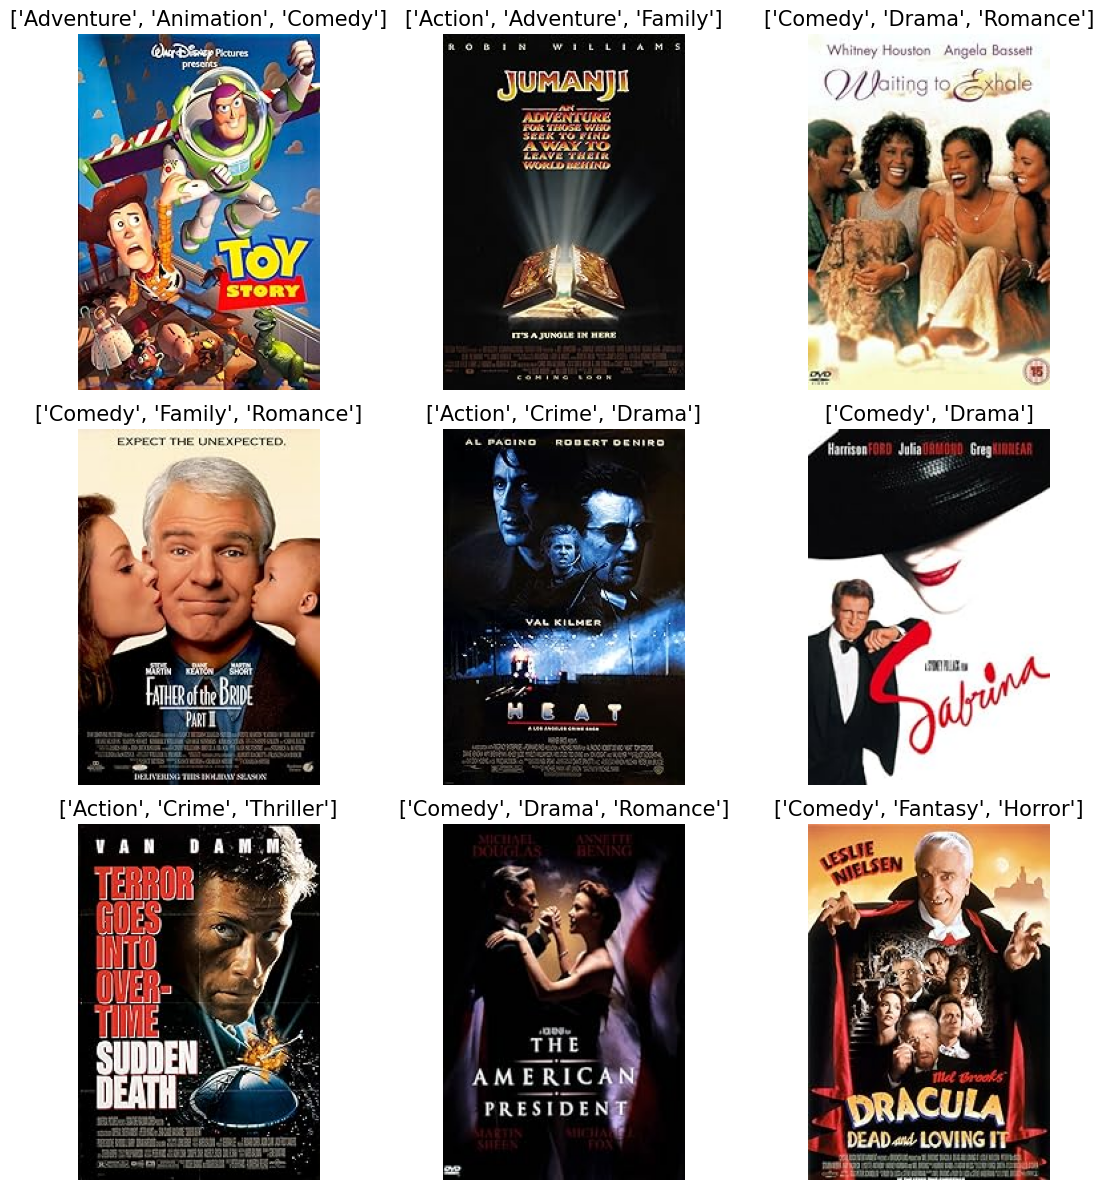

In [4]:
# Print the shapes of the loaded data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(images[i])
	plt.axis('off')
	plt.title([column for column, label in zip(binarized_columns, labels[i]) if label == 1], fontsize=15)
plt.tight_layout()
plt.show()

### Preprocessing

In [5]:
from sklearn.model_selection import train_test_split

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42) #change test_size if want quicker runtime

# Print the shapes of the split datasets
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing images shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training images shape: (29947, 268, 182, 3)
Training labels shape: (29947, 23)
Testing images shape: (3328, 268, 182, 3)
Testing labels shape: (3328, 23)


In [7]:
train_label_distribution = np.sum(y_train, axis=0)
test_label_distribution = np.sum(y_test, axis=0)

combined_data = {
    "Label": binarized_columns,
    "Train Distribution": train_label_distribution,
    "Test Distribution": test_label_distribution
}

df = pd.DataFrame(combined_data)
print(df)

          Label  Train Distribution  Test Distribution
0        Action                4066                422
1     Adventure                2896                289
2     Animation                1320                137
3     Biography                1501                184
4        Comedy                9571               1056
5         Crime                3924                395
6   Documentary                2943                305
7         Drama               15113               1656
8        Family                1592                170
9       Fantasy                1536                158
10    Film-Noir                 238                 31
11      History                1094                118
12       Horror                2985                376
13        Music                 944                113
14      Musical                 594                 65
15      Mystery                1780                193
16      Romance                4533                518
17       S

### Modeling

In [9]:
# Model Specification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
	'google/vit-base-patch16-224-in21k',
	num_labels=len(binarized_columns),
	problem_type="multi_label_classification"
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Testing

In [10]:
# Perform inference
predicted_probabilities = []

for i in range(0, len(X_test), batch_size):
    # Process batch inputs
    batch_inputs = processor(images=X_test[i:i+batch_size], return_tensors="pt")
    batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    
    with torch.no_grad():
        # Forward pass
        outputs = model(**batch_inputs)
    
    # Get the predicted logits
    logits = outputs.logits
    
    # Convert logits to probabilities using sigmoid
    probabilities = torch.sigmoid(logits)
    
    # Append predicted probabilities for this batch
    predicted_probabilities.append(probabilities.cpu().numpy())

# Concatenate predicted probabilities for all batches
predicted_probabilities = np.concatenate(predicted_probabilities, axis=0)


In [11]:
# Convert lists to NumPy arrays
y_test_np = np.array(y_test)
predicted_probabilities_np = np.array(predicted_probabilities)

# Ensure that the arrays have the appropriate shape
y_test_np = np.vstack([np.array(y) for y in y_test_np])

# Define the threshold for binary classification
threshold = 0.5

# Threshold predicted probabilities to obtain binary predictions
predicted_labels_np = (predicted_probabilities_np > threshold).astype(int)

### Evaluation

In [12]:
# Initialize lists to store F1 scores and accuracies for each label
f1_scores = []
accuracies = []
predicted_binary_labels = (predicted_probabilities > threshold).astype(int)

# Iterate over each label
for i, label in enumerate(binarized_columns):
    # Calculate F1 score
    f1 = f1_score(y_test_np[:, i], predicted_labels_np[:, i], average='binary')
    f1_scores.append(f1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test[:, i], predicted_binary_labels[:, i])
    accuracies.append(accuracy)

data = {
    "Label": binarized_columns,
    "F1 Score": f1_scores,
    "Accuracy": accuracies
}

df = pd.DataFrame(data)
print(df)

# Compute average F1 score
avg_f1_score = np.mean(f1_scores)
print("\nAverage F1 score:", avg_f1_score)

# Compute average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print("Average accuracy:", average_accuracy)


          Label  F1 Score  Accuracy
0        Action  0.172356  0.264123
1     Adventure  0.122343  0.491286
2     Animation  0.034771  0.582933
3     Biography  0.100313  0.137620
4        Comedy  0.449959  0.600361
5         Crime  0.210454  0.305589
6   Documentary  0.146893  0.546274
7         Drama  0.552324  0.505108
8        Family  0.120574  0.723858
9       Fantasy  0.092462  0.728666
10    Film-Noir  0.006952  0.742488
11      History  0.060807  0.489483
12       Horror  0.211978  0.347656
13        Music  0.070340  0.761719
14      Musical  0.033632  0.222957
15      Mystery  0.104869  0.353666
16      Romance  0.269568  0.273738
17       Sci-Fi  0.097707  0.184195
18        Short  0.039287  0.206430
19        Sport  0.038278  0.758413
20     Thriller  0.192029  0.731971
21          War  0.056309  0.456130
22      Western  0.045204  0.479567

Average F1 score: 0.1404090735870028
Average accuracy: 0.4736622073578596


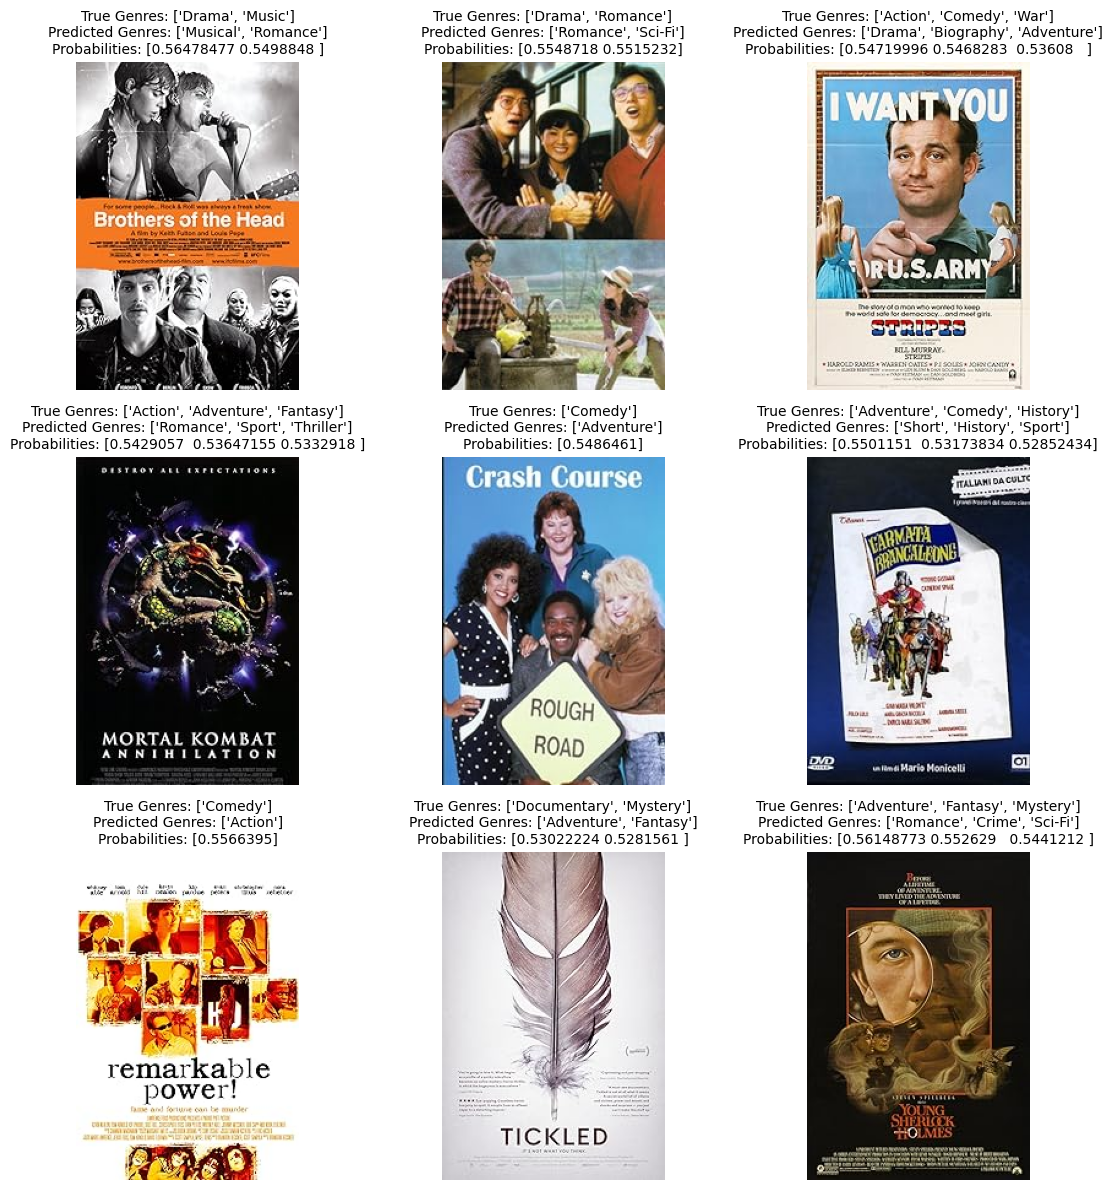

In [13]:
def display(X_test, y_test, predicted_probabilities, binarized_columns, threshold=0.5):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(X_test):
            poster = X_test[idx]
            true_labels = [binarized_columns[i] for i, label in enumerate(y_test[idx]) if label == 1]
            predicted_genre_probabilities = predicted_probabilities[idx]

            # Sort predicted probabilities and select labels based on the number of true labels
            num_true_labels = len(true_labels)
            top_predicted_idx = np.argsort(predicted_genre_probabilities)[::-1][:num_true_labels]
            predicted_genre_labels = [binarized_columns[i] for i in top_predicted_idx]
            top_predicted_probabilities = predicted_genre_probabilities[top_predicted_idx]

            ax.imshow(poster)
            ax.set_title(f"True Genres: {true_labels}\nPredicted Genres: {predicted_genre_labels}\nProbabilities: {top_predicted_probabilities}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
        
    plt.tight_layout()
    plt.show()

display(X_test, y_test, predicted_probabilities, binarized_columns)
